In [91]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import json
import os
import rpy2
import anndata
from datetime import date
from scipy.stats import binom_test
from datetime import datetime

# YYYY-MM-DD
today = date.today()
today = today.strftime("%Y-%m-%d")

import warnings
warnings.filterwarnings('ignore')

# Set up

In [149]:
# Confirm the output path
output_path='/nfs/team205/heart/JC_SNP_enrichment/8region/EBI_GWAS/enrichment_output/'

In [150]:
# select a window size (bp) of interest (by default it is 500bp)

window_size=500
window_adjustment=(window_size-500)/2
print('adjustment '+str(window_adjustment))
window_size_for_filename='peak_width_'+str(window_size)
print(window_size_for_filename)

adjustment 0.0
peak_width_500


### Set threshold for binarisation

In [151]:
# Set threshold for binarisation
threshold=0.05
threshold_for_filename=str(threshold).replace('.','p')
print(threshold_for_filename)

0p05


### Set threshold for LD

In [152]:
LD_threshold=0.9 # threshold (r squared)
LD_threshold_for_filename=str(LD_threshold).replace('.','p')
print(LD_threshold_for_filename)

0p9


### Set P val significance threshold for analysis below

In [153]:
pval_sig_threshold=0.05
neglog10_pval_sig_threshold=np.negative(np.log10(pval_sig_threshold))
neglog10_pval_sig_threshold

1.3010299956639813

# Read in output file

In [154]:
combined_output_df=pd.read_csv(f'{output_path}{threshold_for_filename}_{window_size_for_filename}_SNPs_in_LD{LD_threshold_for_filename}_all_traits_summary.csv',index_col='cell_type')
combined_output_df['efo_term']=combined_output_df['efo_term'].astype(str)#+"_"+combined_output_df['n_SNPs'].astype(str) # Add the n_SNPs - useful for later inspection
combined_output_df

,proportion_of_all_open_peaks_found_in_this_celltype,proportion_of_SNPs_found_in_celltype_specific_open_peaks,mean_proportions_of_SNPs_in_open_peaks,n_times_proportions_of_SNPs_in_permuted_open_peaks_greater_than_observed_proportion,p_value,n_SNPs,efo_id,efo_term
cell_type,,,,,,,,
NC2_glial_NGFpos,0.073318,0.093750,0.071438,388,0.388,315,EFO_0000266,aortic stenosis
T_or_NK_cycling,0.037759,0.000000,0.036687,1000,1.000,315,EFO_0000266,aortic stenosis
DC,0.040123,0.031250,0.041063,685,0.685,315,EFO_0000266,aortic stenosis
DC,0.040123,0.031250,0.041063,685,0.685,315,EFO_0000266,aortic stenosis
AVN_P_cell,0.131460,0.093750,0.129562,751,0.751,315,EFO_0000266,aortic stenosis
...,...,...,...,...,...,...,...,...
Adip3,0.118857,0.161290,0.118968,302,0.302,585,MONDO_0019438,AL amyloidosis
MAIT-like,0.018198,0.032258,0.019065,434,0.434,585,MONDO_0019438,AL amyloidosis
FB5,0.052454,0.096774,0.050968,212,0.212,585,MONDO_0019438,AL amyloidosis


<AxesSubplot:>

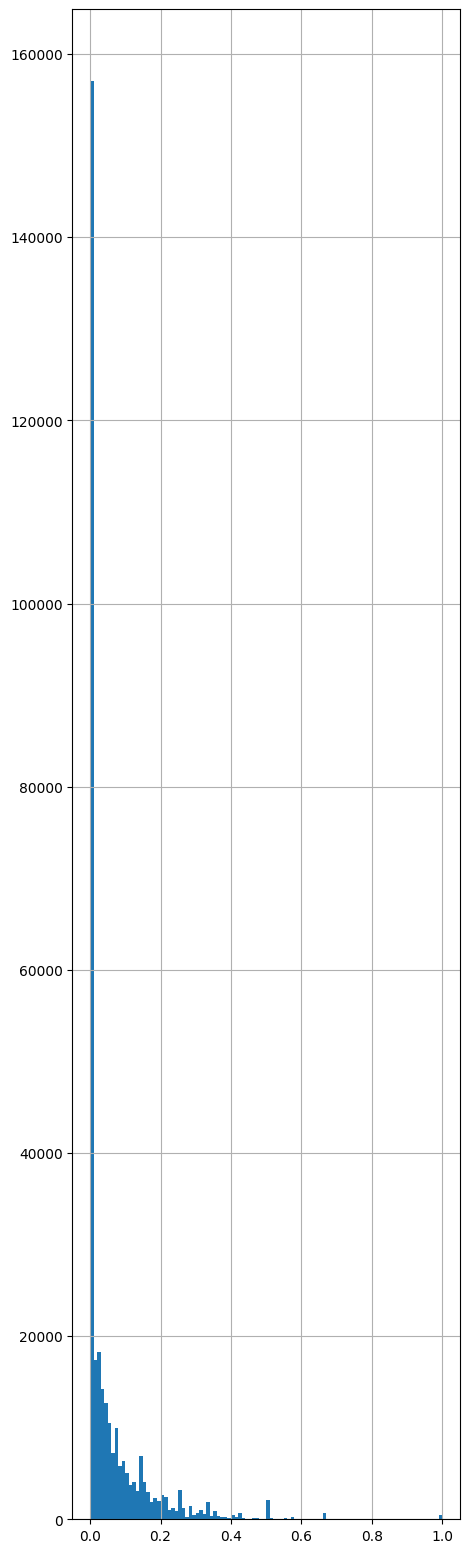

In [155]:
combined_output_df.proportion_of_SNPs_found_in_celltype_specific_open_peaks.hist(bins=100)

In [156]:
#pivot the table to prepare for heatmap
df=combined_output_df[['p_value','efo_term']]
df=df.pivot_table(values='p_value',index='cell_type',columns='efo_term')
df

efo_term,AL amyloidosis,B-type natriuretic peptide to N-terminal pro B-type natriuretic peptide ratio,BNP measurement,Brugada syndrome,Chagas cardiomyopathy,Churg-Strauss syndrome,D dimer measurement,Duchenne muscular dystrophy,JT interval,LH,...,tissue plasminogen activator measurement,treatment-resistant hypertension,uric acid measurement,vascular,vascular dementia,vascular endothelial growth factor measurement,vasoactive peptide measurement,venous thromboembolism,ventricular ectopy,ventricular rate measurement
cell_type,,,,,,,,,,,,,,,,,,,,,
AVN_P_cell,0.016,0.338,0.123,0.100,0.798,0.446,0.279,0.731,0.000,1.000,...,0.122,0.580,0.049,1.000,1.0,0.520,1.0,0.443,1.000,0.583
AVN_bundle_cell,0.075,0.025,1.000,0.214,0.945,0.466,0.085,0.368,0.000,0.803,...,0.097,0.276,0.191,1.000,1.0,0.623,1.0,0.676,0.040,0.818
Adip1,0.596,0.302,1.000,0.272,0.033,1.000,0.121,1.000,0.124,0.760,...,0.015,0.142,0.002,1.000,1.0,0.419,1.0,0.197,1.000,0.693
Adip2,0.482,0.605,1.000,0.254,0.021,1.000,0.110,1.000,0.104,0.704,...,0.011,0.467,0.008,1.000,1.0,0.353,1.0,0.184,1.000,0.629
Adip3,0.302,0.884,0.125,0.559,0.304,1.000,0.088,0.909,0.306,0.919,...,0.050,0.878,0.002,1.000,1.0,0.540,1.0,0.164,1.000,0.212
B,1.000,0.258,1.000,0.157,1.000,1.000,0.590,1.000,0.330,1.000,...,0.009,0.381,0.002,1.000,1.0,0.169,1.0,0.221,1.000,0.735
B_plasma,0.574,0.095,1.000,0.053,1.000,1.000,0.191,1.000,0.091,0.458,...,0.006,0.255,0.007,1.000,1.0,0.262,1.0,0.279,1.000,0.522
CD14posMo,0.182,0.396,1.000,0.259,0.141,1.000,0.064,1.000,0.425,1.000,...,0.002,0.515,0.006,1.000,1.0,0.289,1.0,0.250,1.000,0.850
CD16posMo,0.496,1.000,1.000,0.262,0.382,1.000,0.048,1.000,0.261,1.000,...,0.009,0.165,0.016,1.000,1.0,0.241,1.0,0.246,1.000,0.818


In [157]:
# drop columns where p value is all 1 (i.e. nothing at all significant)
print(df.shape)
df=df.loc[:, (df != 1).any(axis=0)]
print(df.shape)

(60, 176)
(60, 165)


In [158]:
# drop columns where p value is all 0 (i.e. no open peaks)
print(df.shape)
df=df.loc[:, (df != 0).any(axis=0)]
print(df.shape)

(60, 165)
(60, 165)


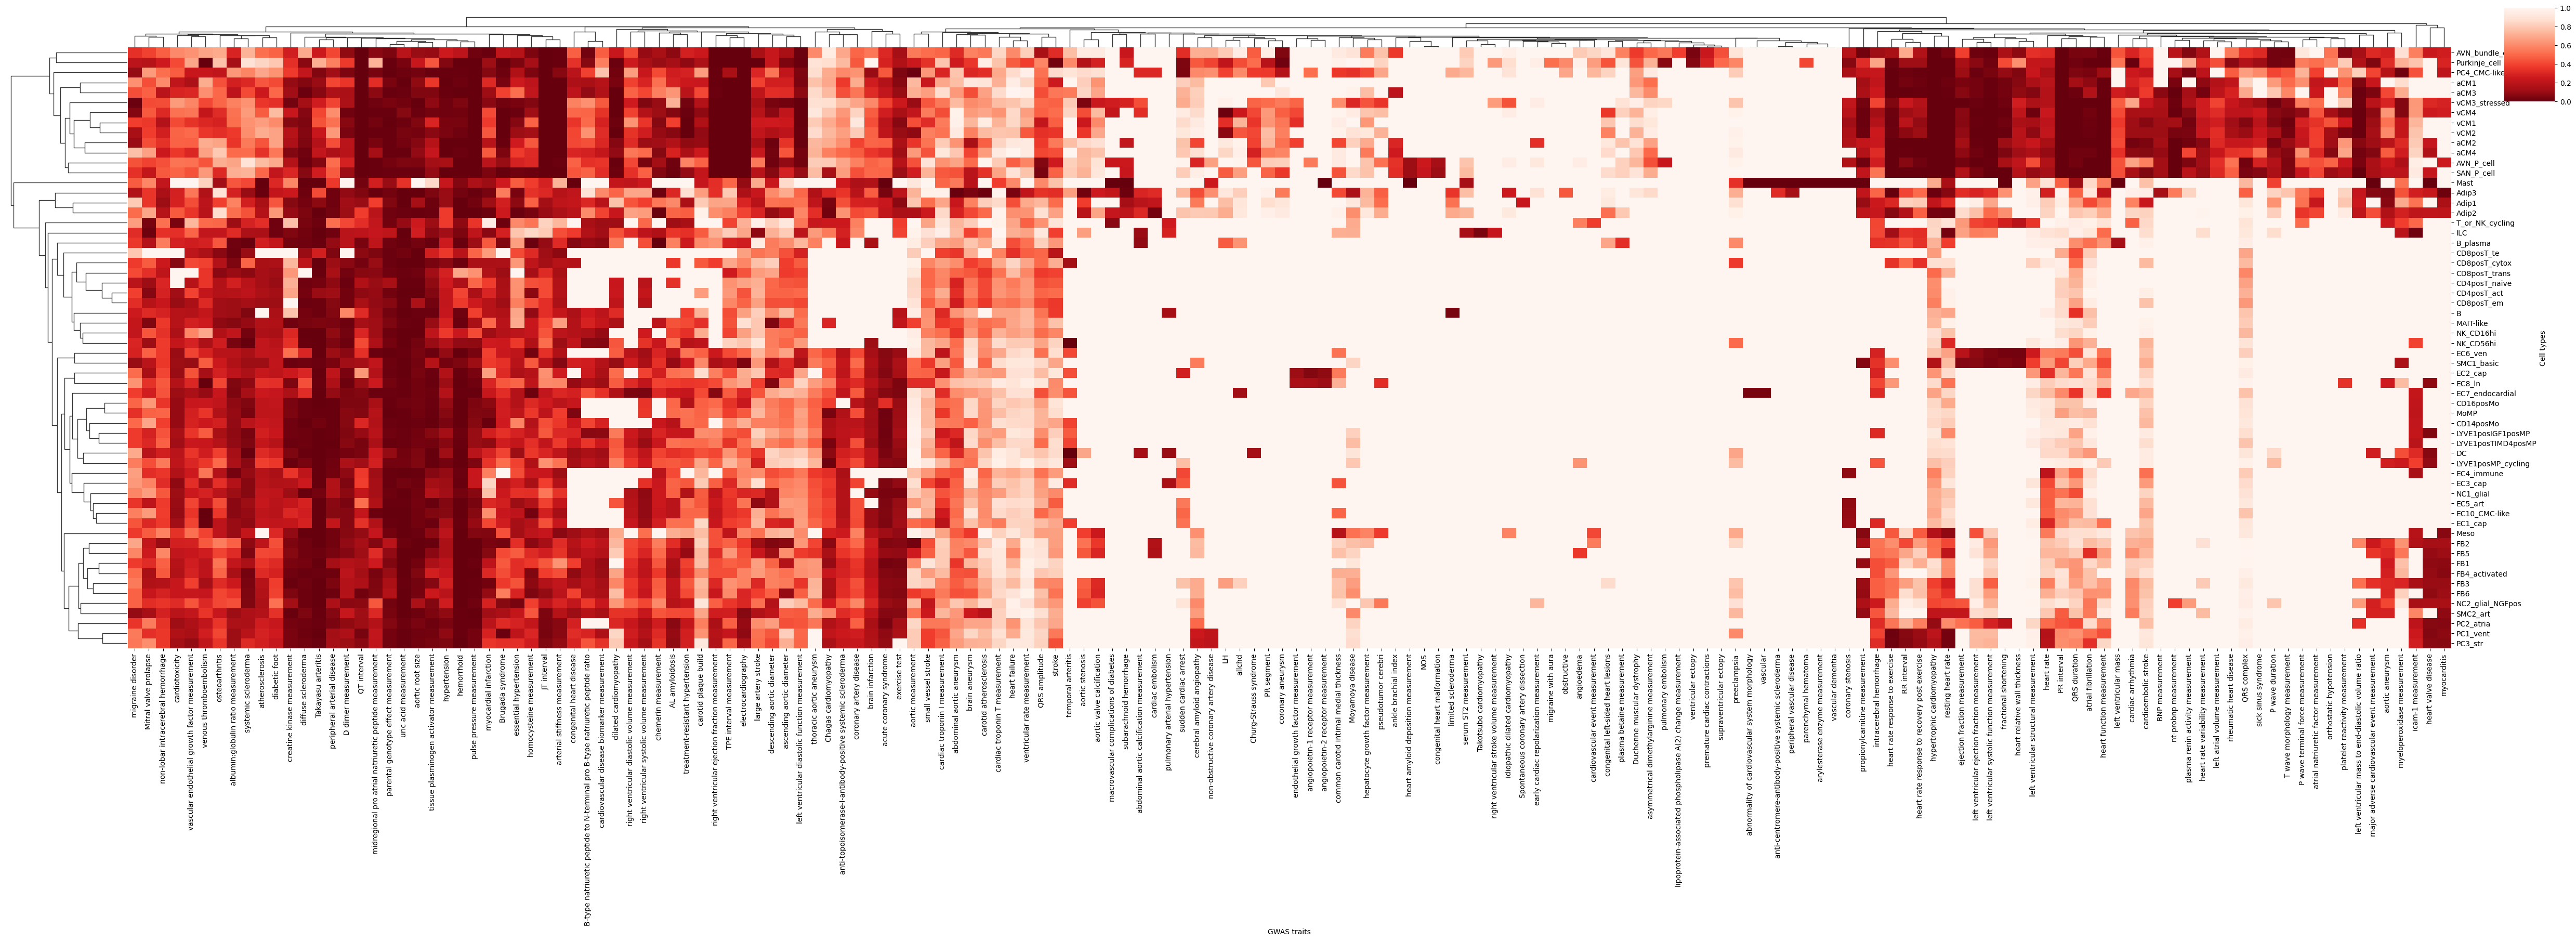

In [159]:
plt.rcParams['figure.dpi'] = 100

tmp=df.loc[:, (df > 0.05).any(axis=0)]
tmp=tmp.loc[(tmp > 0.05).any(axis=1),:]

g=sns.clustermap(tmp,
               xticklabels=True,
               yticklabels=True,
               cmap='Reds_r',
               figsize=(tmp.shape[1]*0.3,tmp.shape[0]*0.3),
#               annot=anno_df,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1)
              )

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)
    
ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.show()

In [160]:
# multiple testing correction
import statsmodels.stats.multitest
from statsmodels.stats.multitest import multipletests

method='fdr_bh'
columns=df.columns.tolist()

# correct for multiple testing (each test being one cell type). Replacing the column with a corrected value
for column in columns:
    df[column]=statsmodels.stats.multitest.multipletests(df[column],method=method)[1]
df

efo_term,AL amyloidosis,B-type natriuretic peptide to N-terminal pro B-type natriuretic peptide ratio,BNP measurement,Brugada syndrome,Chagas cardiomyopathy,Churg-Strauss syndrome,D dimer measurement,Duchenne muscular dystrophy,JT interval,LH,...,thoracic aortic aneurysm,tissue plasminogen activator measurement,treatment-resistant hypertension,uric acid measurement,vascular,vascular dementia,vascular endothelial growth factor measurement,venous thromboembolism,ventricular ectopy,ventricular rate measurement
cell_type,,,,,,,,,,,,,,,,,,,,,
AVN_P_cell,0.480000,0.699310,0.912,0.375000,1.000000,1.0,0.310000,1.0,0.000000,1.00,...,1.0,0.158298,0.696000,0.052500,1.00,1.0,0.611321,0.554400,1.0,0.99661
AVN_bundle_cell,0.578182,0.603000,1.000,0.408000,1.000000,1.0,0.152571,1.0,0.000000,1.00,...,1.0,0.141951,0.626667,0.194237,1.00,1.0,0.667500,0.715932,1.0,0.99661
Adip1,0.701176,0.647143,1.000,0.408000,0.432000,1.0,0.181500,1.0,0.323478,1.00,...,1.0,0.050000,0.626667,0.006316,1.00,1.0,0.576522,0.501081,1.0,0.99661
Adip2,0.640408,0.891429,1.000,0.408000,0.432000,1.0,0.178378,1.0,0.312000,1.00,...,1.0,0.044000,0.662449,0.012973,1.00,1.0,0.576522,0.501081,1.0,0.99661
Adip3,0.640408,1.000000,0.912,0.581379,0.781935,1.0,0.152571,1.0,0.482857,1.00,...,1.0,0.114375,1.000000,0.006316,1.00,1.0,0.611321,0.501081,1.0,0.99661
B,1.000000,0.647143,1.000,0.408000,1.000000,1.0,0.610345,1.0,0.482857,1.00,...,1.0,0.044000,0.662449,0.006316,1.00,1.0,0.576522,0.501081,1.0,0.99661
B_plasma,0.688800,0.603000,1.000,0.227143,1.000000,1.0,0.226154,1.0,0.287368,1.00,...,1.0,0.044000,0.626667,0.012000,1.00,1.0,0.576522,0.501081,1.0,0.99661
CD14posMo,0.578182,0.720000,1.000,0.408000,0.611250,1.0,0.148966,1.0,0.512830,1.00,...,1.0,0.040000,0.662449,0.012000,1.00,1.0,0.576522,0.501081,1.0,0.99661
CD16posMo,0.640408,1.000000,1.000,0.408000,0.781935,1.0,0.148966,1.0,0.463333,1.00,...,1.0,0.044000,0.626667,0.020426,1.00,1.0,0.576522,0.501081,1.0,0.99661


In [161]:
# log-neg transform, then plot

df=np.negative(np.log10(df))
df[df == -0] = 0 # replace '-0' with '0'
df.replace(to_replace=[np.inf, -np.inf], value='inf', inplace=True) # replace infinities with something sensible (the maximum real number found elsewhere in the df)
df.replace(to_replace='inf', value=df.max().max(), inplace=True)

df

efo_term,AL amyloidosis,B-type natriuretic peptide to N-terminal pro B-type natriuretic peptide ratio,BNP measurement,Brugada syndrome,Chagas cardiomyopathy,Churg-Strauss syndrome,D dimer measurement,Duchenne muscular dystrophy,JT interval,LH,...,thoracic aortic aneurysm,tissue plasminogen activator measurement,treatment-resistant hypertension,uric acid measurement,vascular,vascular dementia,vascular endothelial growth factor measurement,venous thromboembolism,ventricular ectopy,ventricular rate measurement
cell_type,,,,,,,,,,,,,,,,,,,,,
AVN_P_cell,0.318759,0.155330,0.040005,0.425969,0.000000,0.0,0.508638,0.0,1.698970,0.000000,...,0.0,0.800525,0.157391,1.279841,0.000000,0.00000,0.213731,0.256177,0.0,0.001475
AVN_bundle_cell,0.237936,0.219683,0.000000,0.389340,0.000000,0.0,0.816527,0.0,1.698970,0.000000,...,0.0,0.847861,0.202963,0.711667,0.000000,0.00000,0.175549,0.145128,0.0,0.001475
Adip1,0.154173,0.189000,0.000000,0.389340,0.364516,0.0,0.741123,0.0,0.490155,0.000000,...,0.0,1.301030,0.202963,2.199572,0.000000,0.00000,0.239184,0.300092,0.0,0.001475
Adip2,0.193543,0.049913,0.000000,0.389340,0.364516,0.0,0.748658,0.0,0.505845,0.000000,...,0.0,1.356547,0.178848,1.886960,0.000000,0.00000,0.239184,0.300092,0.0,0.001475
Adip3,0.193543,0.000000,0.040005,0.235540,0.106829,0.0,0.816527,0.0,0.316181,0.000000,...,0.0,0.941669,0.000000,2.199572,0.000000,0.00000,0.213731,0.300092,0.0,0.001475
B,0.000000,0.189000,0.000000,0.389340,0.000000,0.0,0.214425,0.0,0.316181,0.000000,...,0.0,1.356547,0.178848,2.199572,0.000000,0.00000,0.239184,0.300092,0.0,0.001475
B_plasma,0.161907,0.219683,0.000000,0.643701,0.000000,0.0,0.645596,0.0,0.541561,0.000000,...,0.0,1.356547,0.202963,1.920819,0.000000,0.00000,0.239184,0.300092,0.0,0.001475
CD14posMo,0.237936,0.142668,0.000000,0.389340,0.213781,0.0,0.826914,0.0,0.290026,0.000000,...,0.0,1.397940,0.178848,1.920819,0.000000,0.00000,0.239184,0.300092,0.0,0.001475
CD16posMo,0.193543,0.000000,0.000000,0.389340,0.106829,0.0,0.826914,0.0,0.334106,0.000000,...,0.0,1.356547,0.202963,1.689827,0.000000,0.00000,0.239184,0.300092,0.0,0.001475


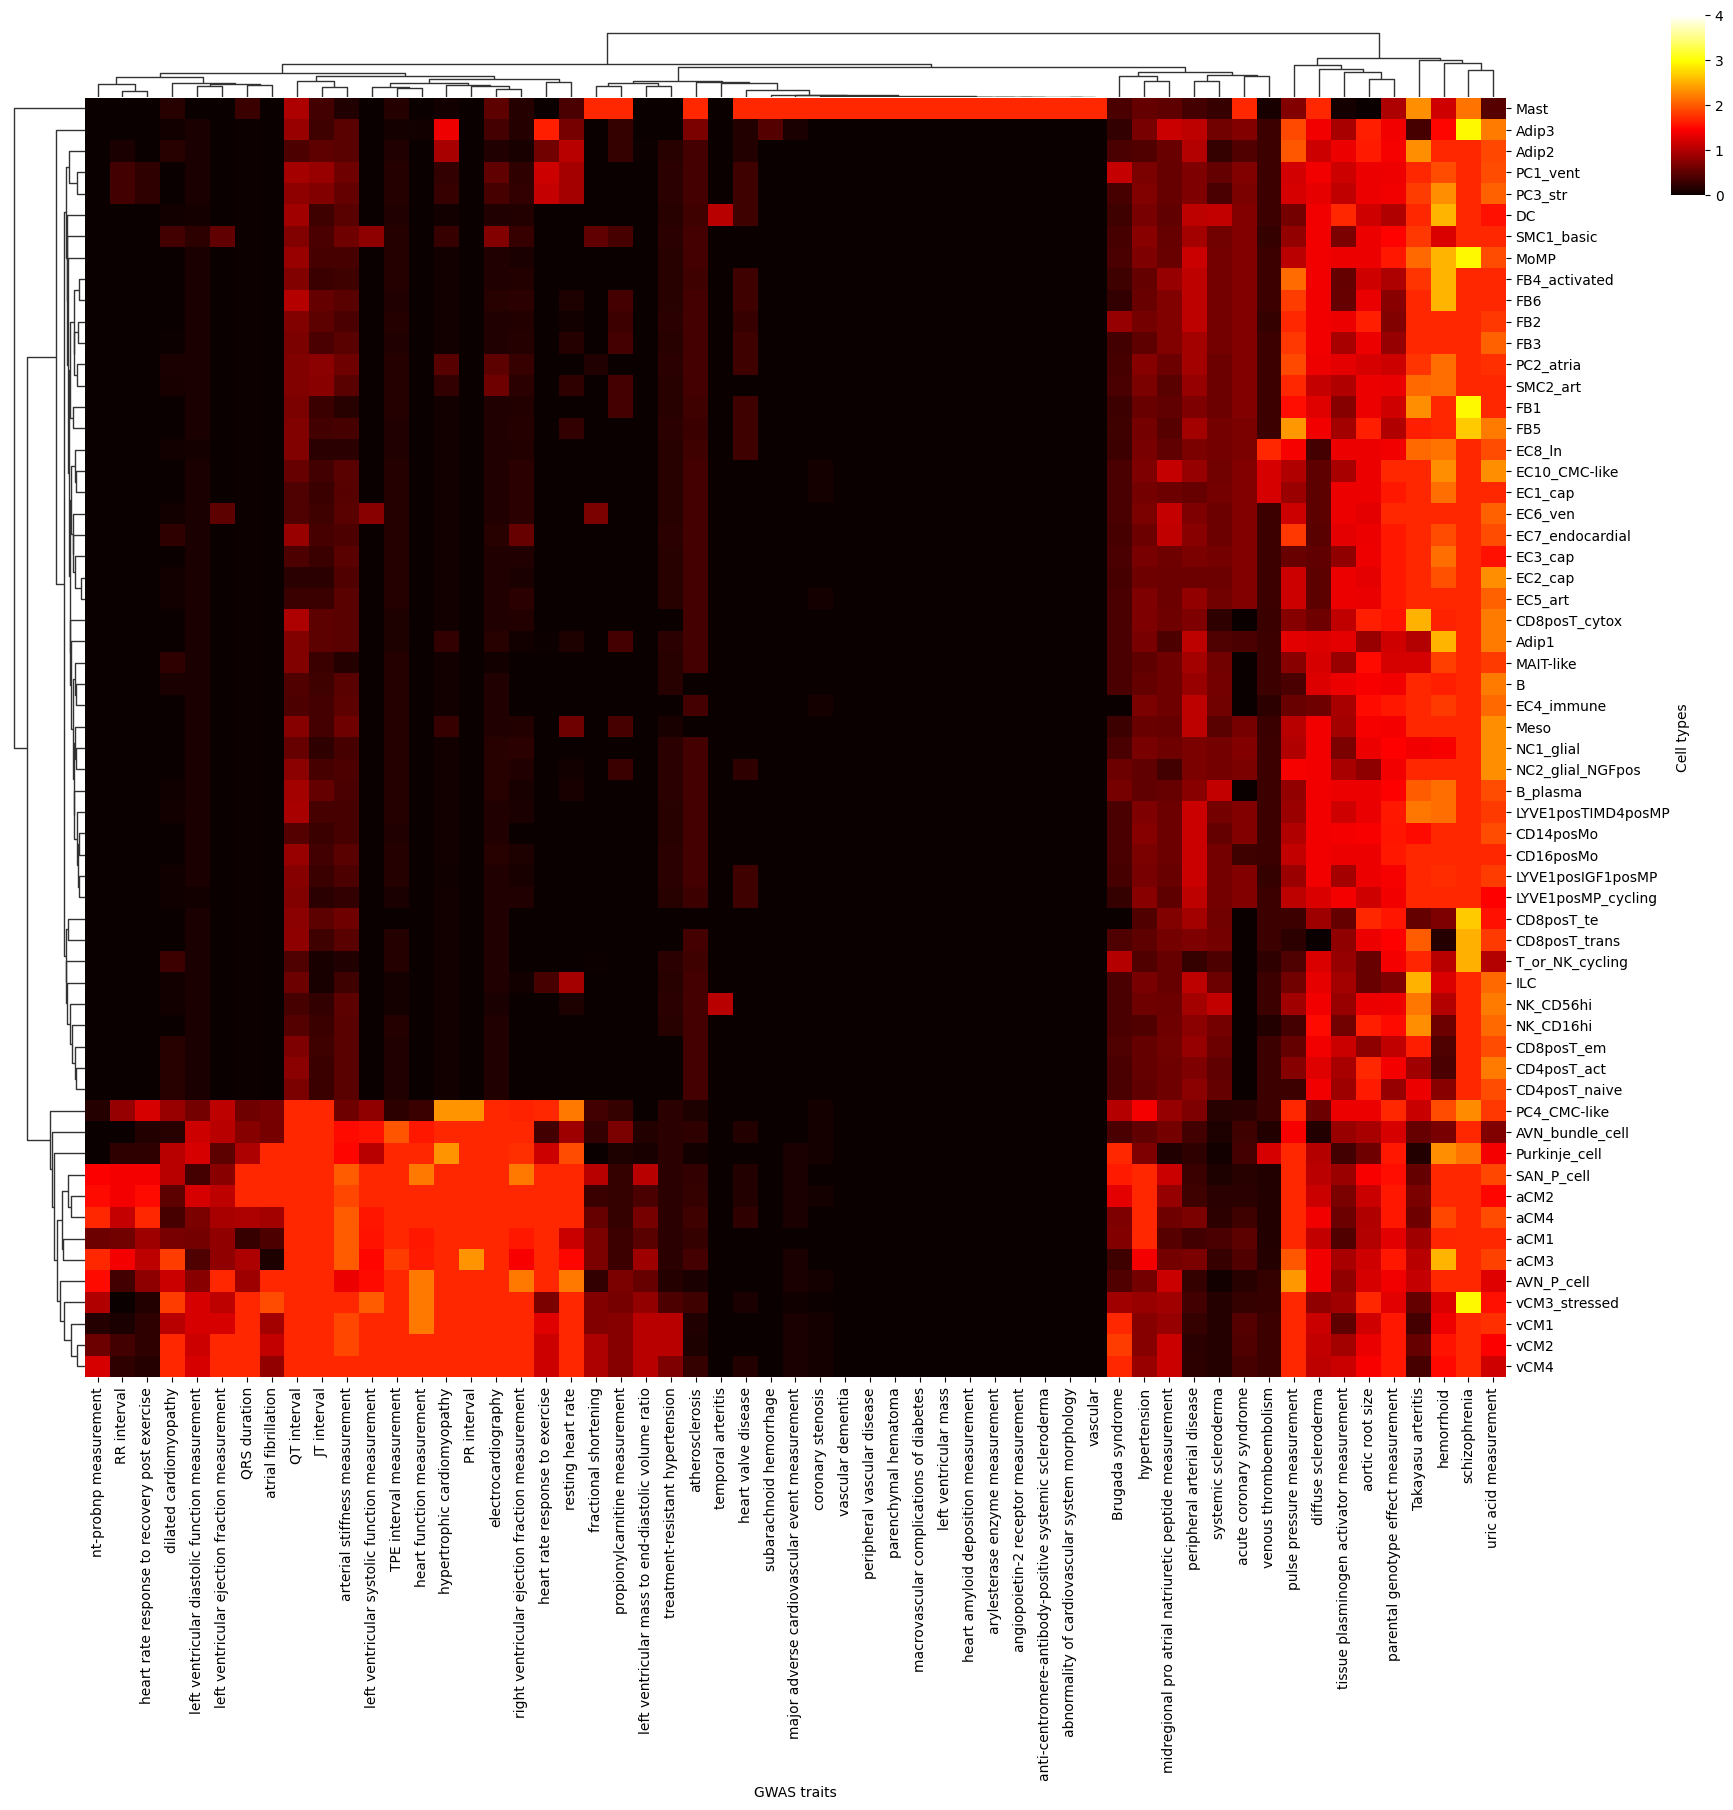

In [162]:
plt.rcParams['figure.dpi'] = 100

tmp=df.loc[:, (df > 1).any(axis=0)]
tmp=tmp.loc[(tmp > 1).any(axis=1),:]



g=sns.clustermap(tmp,
               xticklabels=True,
               yticklabels=True,
               cmap='hot',
               figsize=(tmp.shape[1]*0.3,tmp.shape[0]*0.3),
#               annot=anno_df,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),
                 vmax=4
              )


for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)
    
ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.savefig(f'{output_path}overview_heatmap_{threshold_for_filename}_SNP_enrichment.png')
plt.show()

In [163]:
# Remove any columns where there are no significant values, then the same for cols

df=df.loc[:, (df > neglog10_pval_sig_threshold).any(axis=0)]
df=df.loc[(df > neglog10_pval_sig_threshold).any(axis=1),:]

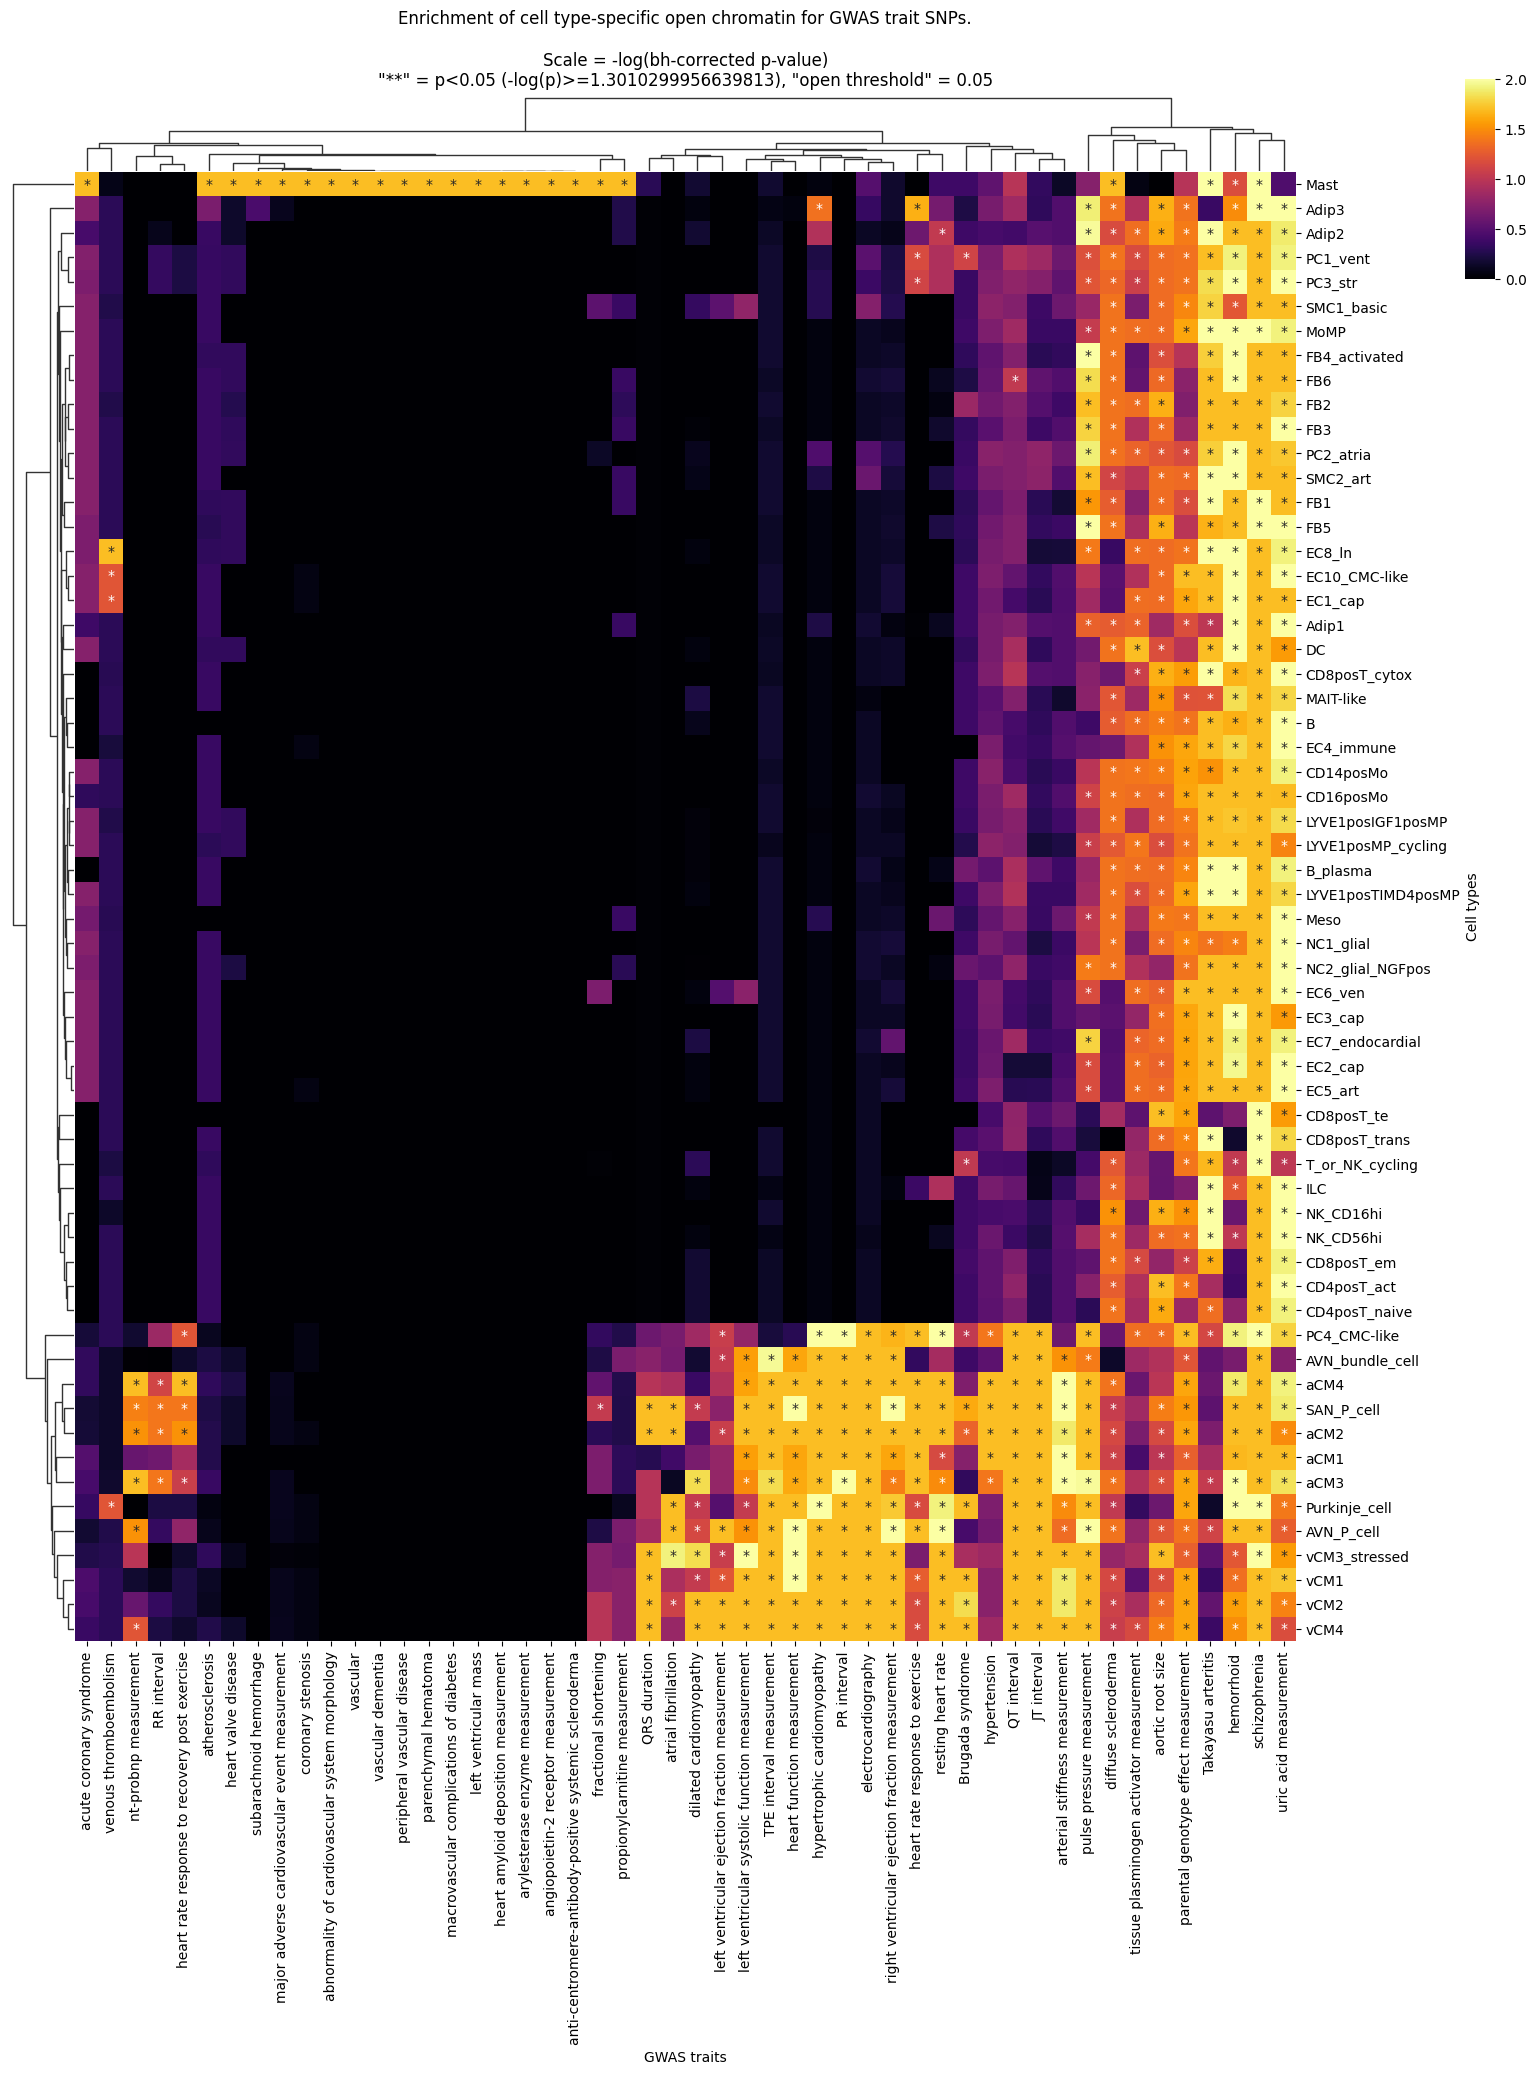

In [164]:
plt.rcParams['figure.dpi'] = 100

# Make annotation df
anno_df=df.where(df<1, other="*")
anno_df=anno_df.where(anno_df=='*', other=" ")
anno_df=anno_df.astype(str)


g=sns.clustermap(df,
               xticklabels=True,
               yticklabels=True,
               cmap='inferno',
               figsize=(15,20),
               annot=anno_df,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),
                 vmax=2
              )

g.ax_col_dendrogram.set_title(f'Enrichment of cell type-specific open chromatin for GWAS trait SNPs.\n\nScale = -log(bh-corrected p-value)\n"**" = p<{pval_sig_threshold} (-log(p)>={neglog10_pval_sig_threshold}), "open threshold" = {threshold}')

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)
    
ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.savefig(f'{output_path}overview_heatmap_{threshold_for_filename}_SNP_enrichment.png')
plt.show()

In [165]:
# remove traits not of interest for this study
df.columns

Index(['Brugada syndrome', 'JT interval', 'PR interval', 'QRS duration',
       'QT interval', 'RR interval', 'TPE interval measurement',
       'Takayasu arteritis', 'abnormality of cardiovascular system morphology',
       'acute coronary syndrome', 'angiopoietin-2 receptor measurement',
       'anti-centromere-antibody-positive systemic scleroderma',
       'aortic root size', 'arterial stiffness measurement',
       'arylesterase enzyme measurement', 'atherosclerosis',
       'atrial fibrillation', 'coronary stenosis', 'diffuse scleroderma',
       'dilated cardiomyopathy', 'electrocardiography',
       'fractional shortening', 'heart amyloid deposition measurement',
       'heart function measurement', 'heart rate response to exercise',
       'heart rate response to recovery post exercise', 'heart valve disease',
       'hemorrhoid', 'hypertension', 'hypertrophic cardiomyopathy',
       'left ventricular ejection fraction measurement',
       'left ventricular mass',
       'left

In [166]:
drop_cols=['Brugada syndrome', 'JT interval', 'TPE interval measurement', 'Takayasu arteritis',
       'abnormality of cardiovascular system morphology',
       'acute coronary syndrome', 'angiopoietin-2 receptor measurement',
       'anti-centromere-antibody-positive systemic scleroderma',
       'aortic root size', 'arterial stiffness measurement',
       'arylesterase enzyme measurement', 'atherosclerosis', 'coronary stenosis',
       'diffuse scleroderma', 'dilated cardiomyopathy',
       'electrocardiography', 'fractional shortening',
       'heart amyloid deposition measurement','heart valve disease', 'hemorrhoid', 'hypertension','macrovascular complications of diabetes',
       'major adverse cardiovascular event measurement',
       'nt-probnp measurement', 'parenchymal hematoma',
       'parental genotype effect measurement',
       'peripheral vascular disease', 'propionylcarnitine measurement','right ventricular ejection fraction measurement',
       'schizophrenia', 'subarachnoid hemorrhage',
       'tissue plasminogen activator measurement',
       'uric acid measurement', 'vascular dementia', 'vascular',
#       'venous thromboembolism_6831',
           'left ventricular mass','hypertrophic cardiomyopathy','heart function measurement',
           'atrial fibrillation',
           'left ventricular systolic function measurement',
           'resting heart rate'
    
]

df=df.drop(columns=drop_cols)

In [168]:
df.index = pd.CategoricalIndex(df.index, categories= ['Adip1', 'Adip2', 'Adip3', 'B',
       'B_plasma', 'CD4posT_act', 'CD4posT_naive',
       'CD8posT_cytox', 'CD8posT_em', 'CD8posT_te', 'CD8posT_trans', 'T_or_NK_cycling','NK_CD16hi', 'NK_CD56hi','MAIT-like', 'ILC', 
        'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune',
       'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln','EC10_CMC-like','FB1', 'FB2', 'FB3',
       'FB4_activated', 'FB5', 'FB6', 'DC','LYVE1posIGF1posMP',
       'LYVE1posMP_cycling', 'LYVE1posTIMD4posMP', 'Mast', 'Meso',
       'MoMP', 'CD14posMo', 'CD16posMo','NC1_glial', 'NC2_glial_NGFpos', 
       'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 
       'SMC1_basic', 'SMC2_art', 'SAN_P_cell','AVN_P_cell','AVN_bundle_cell','Purkinje_cell', 'aCM1',
       'aCM2', 'aCM3', 'aCM4', 'vCM1', 'vCM2', 'vCM3_stressed', 'vCM4'])
df.sort_index(level=0, inplace=True)

In [180]:
df.columns = map(str.upper, df.columns)
df.rename(columns = {'PULSE PRESSURE MEASUREMENT':''}, inplace = True)
df = df.reindex(sorted(df.columns), axis=1)
df=df.loc[:, ['BLOOD PRESSURE', 'HEART RATE RESPONSE TO EXERCISE',
       'HEART RATE RESPONSE TO RECOVERY POST EXERCISE',
       'LEFT VENTRICULAR EJECTION FRACTION MEASUREMENT', 'PR INTERVAL',
       'QRS DURATION', 'QT INTERVAL',
       'RR INTERVAL', 'VENOUS THROMBOEMBOLISM']]
df.columns

Index(['BLOOD PRESSURE', 'HEART RATE RESPONSE TO EXERCISE',
       'HEART RATE RESPONSE TO RECOVERY POST EXERCISE',
       'LEFT VENTRICULAR EJECTION FRACTION MEASUREMENT', 'PR INTERVAL',
       'QRS DURATION', 'QT INTERVAL', 'RR INTERVAL', 'VENOUS THROMBOEMBOLISM'],
      dtype='object')

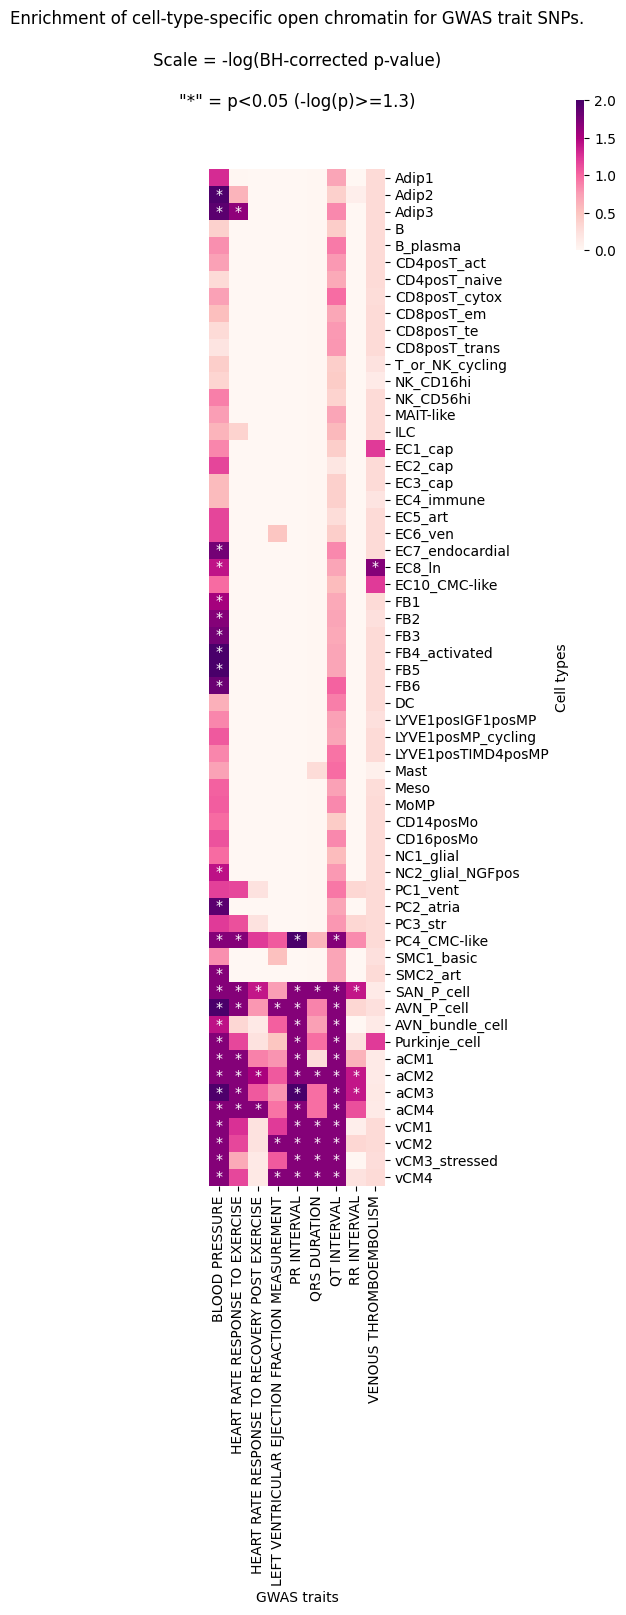

In [185]:
plt.rcParams['figure.dpi'] = 100

# Make annotation df
anno_df=df.where(df<neglog10_pval_sig_threshold, other="*")
anno_df=anno_df.where(anno_df=='*', other=" ")
anno_df=anno_df.astype(str)


g=sns.clustermap(df,
               xticklabels=True,
               yticklabels=True,
               cmap='RdPu',
               figsize=(4,15),
               annot=anno_df,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),
                 vmax=2,
                 row_cluster=False, col_cluster=False,
              )

g.ax_col_dendrogram.set_title(f'Enrichment of cell-type-specific open chromatin for GWAS trait SNPs.\n\nScale = -log(BH-corrected p-value)\n\n"*" = p<{pval_sig_threshold} (-log(p)>={round(neglog10_pval_sig_threshold,2)})')

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.savefig(f'{output_path}overview_heatmap_{threshold_for_filename}_SNP_enrichment_physiological.pdf',bbox_inches='tight')
plt.show()